In [133]:
import numpy as np
from scipy import constants
import scipy.interpolate
import time
import math
#import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from astropy.io import ascii
#from astropy.io import fits
from astropy.table import Table
#import scipy
#from astropy.constants import h, c
%matplotlib inline


In [134]:
def mag2flux(mag, zero_pt=21.1, ABwave=None):
    if ABwave != None:
        return 10.**(-0.4*(mag+2.406+5*np.log10(ABwave)))
    return 10.**(-0.4*(mag+zero_pt))

In [135]:
def planck(wave, temp):
    w=wave/1e8
    c1 =  3.7417749e-5  #=2*!DPI*h*c*c   
    c2 = 1.4387687    # =h*c/k
    val=c2/w/temp
    bbflux=c1/(w**5 * (math.e**val-1))*1e-8
    return bbflux


In [136]:
def gen_cal(wave, cdir, calname, cspline):
    calfilename=cdir+'calibration_line_list_'+calname+'_171024.txt'
    calfile=ascii.read(calfilename, data_start=0, format='basic')
    lwave=calfile.columns[0]
    lflux=calfile.columns[1]
            
    nline=len(lwave)
    nwave=len(wave)
    flux_out=wave*0.
    
    for i in range(nline):
        if (lwave[i] < wave[0]) or (lwave[i] > wave[-1]):
            continue
        diff=np.absolute(wave-lwave[i])
        sort_idx=np.argsort(diff)
        nrst_idx=sort_idx[0]
        if nrst_idx == (len(wave)-1):
            continue
        binsize=wave[nrst_idx+1]-wave[nrst_idx]
        nflux=lflux[i]/binsize
        flux_out[nrst_idx]=nflux*1e-17
    return flux_out
        

In [137]:
def flux2bpmag(flam, wave, filtertrans_input, filterwave=None,
               errflag=None, flam_err=None, bpmag_err=None):

    mintrans=0.00011
    filtertrans=np.copy(filtertrans_input)
    if filterwave != None:
        #filtertrans=interpol(filtertrans, filterwave, wave)
        filtertrans=scipy.interpolate.spline(filterwave, filtertrans, wave)
        
    filtertrans=(filtertrans >= mintrans)*filtertrans
    
    nwave=len(wave)

    if len(filtertrans) != nwave:
        errflag=1
        return
    
    constc=constants.c
    #constc=299792458.
    #filtertrans=filtertrans.astype('d')

    flux=np.sum(flam*filtertrans)
    #print('bpflux')
    #print(flux)
    #print(filtertrans)
#       refflam=replicate(3631.d-23, nwave)/wave^2.*!const.c*1.d10
    #refflam=replicate(3631.d-23, nwave)/wave^2.*constc*1.d10
    
    refflam=np.ones(nwave)*3631e-23/(wave**2.)*constc*1e10
    
    refflux=np.sum(refflam*filtertrans)
    #print(refflux)
    #print(flux)
    if flam_err != None:
        err=(np.sum((flam_err*filtertrans)**2))**0.5
        bpmag_err=-2.5/np.log(10)/flux*err

    bpmag=-2.5*np.log10(flux/refflux)
    return bpmag
 

In [138]:
def return_littrow_ghost(wave, signal, ccdreflect, cam, g1stR, g1st, g0th):
#       lghost=return_littrow_ghost(wave,signal+skysignal, ccdreflect, camtrans, g1stR, g1st, g0th)
    rsub=0.01 #;reflectivity of the grating substrate
    lghost1=np.sum(signal*ccdreflect*cam*cam*g1stR)
    lghost2=np.sum(signal*ccdreflect*cam*cam*g1st*rsub*g0th)
    print('Littrow ghost 1 and 2 ', lghost1, lghost2)
    lgwave=4800.
    lghost=signal*0

    diff=np.absolue(wave-lgwave)
    sort_idx=np.argsort(diff)
    nrst_idx=sort_idx[0]
    binsize=wave[nrst_idx+1]-wave[nrst_idx]
    

    tghost=(lghost1+lghost2)
    
    lghost[nrst_idx]=tghost
    return lghost

In [170]:
def return_flux(source, wave, magnitude, band, z, exptime, wstep, cdir, 
                bbtemp, stype, cspline):
 #Identify source type
    consth=constants.h
    constc=constants.c
    src_check=source.split('_')
    src_type=src_check[0]
    skyflag=0
    calflag=0
    if len(src_check) == 2:
        src_value=src_check[1]

    
    nwave=len(wave)

    if src_type =='const':
        magarr=np.ones(nwave)*magnitude
        photone=consth*1e7*constc/(wave*1e-10)
        sourceflux=mag2flux(magnitude, ABwave=wave)
        temptitle='Constant Magnitude of '+str(magnitude)
        calflag=1
        #constflux=replicate(sourceflux[n_elements(sourceflux)/2], nwave)
        #sourceflux=constflux
    
    if src_type =='gal':
        galtempname=cdir+'kc96/'+src_value+'_template.ascii'
        galfile=ascii.read(galtempname, data_start=0, format='basic')
        galwave=galfile.columns[0]*(1.+z)
        galflam=galfile.columns[1]/(1.+z)
        if cspline:
            galflux=scipy.interpolate.spline(galwave, galflam, wave) 
        else:
            galflux=np.interp(wave, galwave, galflam) 

        bpmag=flux2bpmag(galflux, wave, band)

        ratio=10.**(-0.4*(magnitude-bpmag))
        sourceflux=ratio*galflux
                
        
        #cflux=sourceflux
        #cflux=galflux
        #print('bpmag')
        #print(bpmag)
        
        sourceflux=sourceflux*((wave >= min(galwave)) & (wave <= max(galwave)))
        temptitle=src_value+'Type Galaxy'
        temptitle=galtempname
        skyflag=1
    
#    if src_type =='skyflat':

    if src_type =='arcflat':
        arcname=cdir+'Xenon_lamp.txt'
        arcfile=ascii.read(arcname, data_start=0)
        xwave=arcfile.columns[0]
        xflam=arcfile.columns[1]
        if cspline:
            sourceflux=scipy.interpolate.spline(xwave, xflam, wave)*10.**(-12.)
        else:
            sourceflux=np.interp(wave, xwave, xflam)*10.**(-12.)
        
        sourceflux=sourceflux*((wave >= min(xwave)) & (wave <= max(xwave)))
        temptitle='Xenon Arc Lamp'
        calflag=1

    if src_type =='blackbody':
        sourceflux=planck(wave, bbtemp)*0.015**2.*np.pi/(1e5)**2
        temptitle='Black Body (T='+str(bbtemp)+' K'
        calflag=1

    if src_type =='wavecal':
        sourceflux=gen_cal(wave, cdir, src_value, cspline)
        temptitle='Wavelength Calibration Source - '+src_value
        calflag=1
    
    if src_type =='sky':
        skyfilearr=['sky150701_newmoon_alt90.dat',
                    'sky160311_newmoon_alt45.dat',
                    'sky160311_halfmoon.dat',
                    'sky160311_fullmoon.dat']
        skyname=cdir+skyfilearr[stype]
        #skyfile=ascii.read(skyname, data_start=37)
        #skywave=skyfile['col1']*10
        #skyflam=skyfile['col2']
        skyfile=ascii.read(skyname, data_start=24, format='fast_basic', delimiter=' ')
        skywave=skyfile.columns[0]*10
        skyunitcount=skyfile.columns[1]
        
        skyphotone=consth*1e7*constc/(skywave*1e-10)
        skycount=skyunitcount*1e-4*1e-4
        skyflam=skycount*skyphotone
        if cspline:
            skyflux=scipy.interpolate.spline(skywave, skyflam, wave)
        else:
            skyflux=np.interp(wave, skywave, skyflam)
        skyflux=skyflux*((wave >= min(skywave)) & (wave <= max(skywave)))
        #print('skyflux')
        #print(skyflux)
        #print(constc)
        
        bpmag=flux2bpmag(skyflux, wave, band)
        if magnitude != None:
            ratio=10.**(-0.4*(magnitude-bpmag))
            skyflux=ratio*skyflux
        sourceflux=skyflux
        temptitle=skyfilearr[stype]
        calflag=1

    
    return sourceflux, temptitle, skyflag, calflag

In [171]:
#class dotifs_etc(object):
#    def __init__(self, exptime=900, band='r', magnitude=20., skymagnitude=22,
 #                oname='snr.ps', galtemp=False, z=0., inputflux=None, inputwave=None, 
#                 #bbtemp=False, wavecal=False, skyflat=False, arcflat=False,
#                 source='gal_sc', bbtemp=5000, scflag=False, 
#                 stype=0, skymagnitude=22., nofilter=False,
#                 noplot=False, plotrange=[3700, 7400], wstep=(3700./3000), pixel=None, 
#                 cspline=False, wavearr=None,
#                 waveout=None, snrout=None, signalarr=None, skysignalarr=None, noisearr=None, noiseskyarr=None, 
#                 dtypes=None, ofile='outdata.txt', 
#                 pri=3.6, sec=0.915, skysamplingsize=0.4**2*math.pi, dispersion=3700/(3000*15), pixelsize=15,
#                 npix_spa=5, rn=2, dark=0,
#                 cdir='/home/hchung/dotifs/py_etc/',
#                ):


#np.set_printoptions(threshold=np.nan)
exptime=3600
band='r'
magnitude=20.
skymagnitude=20.
oname='snr.ps'
galtemp=False
z=0.
inputflux=None
inputwave=None
#bbtemp=False, wavecal=False, skyflat=False, arcflat=False,
source='gal_sc'
source='wavecal_HgNe'
bbtemp=5000
scflag=False, 
stype=0
skymagnitude=22.
nofilter=False
noplot=False
plotrange=[3700, 7400]
wstep=(3700./3000)
pixel=3
cspline=False
wavearr=None
waveout=None
snrout=None
signalarr=None
skysignalarr=None
noisearr=None
noiseskyarr=None
dtypes=None
ofile='outdata.txt'
pri=3.6
sec=0.915
skysamplingsize=0.4**2*math.pi
dispersion=3700/(3000*15)
pixelsize=15
npix_spa=5
rn=2
dark=0
cdir='/home/hchung/dotifs/py_etc/'


use_asahi=1
ltrghost=False
consth=constants.h
constc=constants.c
temptitle='None'

ifutrans=0.85*0.9
telaream2=(pri**2-sec**2)/4*math.pi         #in m^2
telarea=telaream2*1e4                           #in cm^2
pixelscale=dispersion*pixelsize
if pixel != None:
    wstep=pixel*pixelscale
if pixel == None:
    pixel=wstep/pixelscale

stwave=plotrange[0]
edwave=plotrange[1]


transfname=cdir+'trans150626.dat'
#data=ascii.read(transfile, format='no_header')
transfile=ascii.read(transfname, data_start=1, format='fast_basic', delimiter='\t')
wavemicron=np.array(transfile['micron'])
waveang=wavemicron*1e4
skytrans=np.array(transfile['SkyTrans'])
telmag=np.array(transfile['telandmag'])
col=np.array(transfile['col'])
cam=np.array(transfile['cam'])
#        ccd=np.array(transfile['ccd'])
g0th_o=np.array(transfile['0th'])
g1st_o=np.array(transfile['1st'])
g2nd_o=np.array(transfile['2nd'])

vphfname=cdir+'vph_160307_new.dat'
vphfile=ascii.read(vphfname, data_start=1, format='fast_basic', delimiter='\t')

coatfname=cdir+'altcoating.dat'
coatfile=ascii.read(coatfname, data_start=1, format='basic')     

ccdfname=cdir+'ccd_multi2.txt'
ccdfile=ascii.read(ccdfname, data_start=1, format='fast_basic', delimiter='\t')

bandname=cdir+band+'filter.dat'
bandfile=ascii.read(bandname, data_start=2, format='basic')

afiltername=cdir+'asahi_filter_01.dat'
afilterfile=ascii.read(afiltername, data_start=1, format='basic')
awave=afilterfile.columns[0]
atrans=afilterfile.columns[1]
awave=np.flip(awave,0)*10
atrans=np.flip(atrans,0)/100


if wavearr == None:
    nwave=int((waveang[-1]-waveang[0])/wstep)+1
    wave=np.linspace(0, nwave-1, num=nwave)*wstep+waveang[0]
    diffwave=wave-stwave
    abovezeroidx=np.nonzero(diffwave >=0)
    offwave=min(diffwave[abovezeroidx])
    wave=wave-offwave
else:
    wave=np.array(wavearr)
    nwave=len(wavearr)


idx=np.nonzero((wave > 3700) & (wave < 7400))


if cspline:
    eff_vph_new=scipy.interpolate.spline(vphfile['wave_new'],
                                         vphfile['vph_trans'],
                                         waveang/10)
    eff_coat=scipy.interpolate.spline(coatfile['wavenm'],
                                      coatfile['t0'],
                                      waveang/10)/100
    ccd=scipy.interpolate.spline(ccdfile['Wave'],
                                 ccdfile['QE'],
                                 waveang/10)
    band=scipy.interpolate.spline(bandfile.columns[0],
                                  bandfile.columns[1],
                                  wave)
    afilter=scipy.interpolate.spline(awave, atrans, wave)
else:
    eff_vph_new=np.interp(waveang/10,vphfile['wave_new'],vphfile['vph_trans'])
    eff_coat=np.interp(waveang/10, coatfile['wavenm'], coatfile['t0'])/100
    ccd=np.interp(waveang/10,ccdfile['Wave'],ccdfile['QE'])
    band=np.interp(wave, bandfile.columns[0], bandfile.columns[1])
    #afilter=np.interp(wave, afilterfile['col1']*10,afilterfile['col2']/100)
    afilter=np.interp(wave, awave,atrans)
    

eff_vph_new=eff_vph_new*((waveang/10 >= min(vphfile['wave_new'])) & (waveang/10 <= max(vphfile['wave_new'])))
eff_coat=eff_coat*((waveang/10 >= min(coatfile['wavenm'])) & (waveang/10 <= max(coatfile['wavenm'])))
ccd=ccd*((waveang/10 >= min(ccdfile['Wave'])) & (waveang/10 <= max(ccdfile['Wave'])))
band=band*((wave >= min(bandfile.columns[0])) & (wave <= max(bandfile.columns[0])))
afilter=afilter*((wave >= min(awave)) & (wave <= max(awave)))

    
col=col/0.995**14.*eff_coat**14.
cam=cam/0.995**18.*eff_coat**18.

g1st=eff_vph_new
g0th=g1st/g1st_o*g0th_o
g2nd=g1st/g1st_o*g2nd_o
g1stR=g1st*5*10.**(-5)


#waveang=tfile['micron']*1e4



skyflag=0
photone=consth*1e7*constc/(wave*1e-10)
sourceflux, temptitle, skyflag, calflag=return_flux(source, wave, magnitude, band, z, 
                                           exptime, wstep, cdir, bbtemp, stype, cspline)
                                           
#print(temptitle)
#skyflux, n1, n2=return_flux('sky', wave, skymagnitude, band, z, 
skyflux, n1, n2, n3=return_flux('sky', wave, skymagnitude, band, z,                             
#skyflux, , , =return_flux('sky', wave, skymagnitude, band, z,                             
                            exptime, wstep, cdir, bbtemp, stype, cspline)
                

sourcecount=(sourceflux/photone)*wstep*telarea*exptime*skysamplingsize
skycount=(skyflux/photone)*wstep*telarea*exptime*skysamplingsize

comtrans=telmag*ifutrans*col*cam*ccd
t1st=comtrans*g1st
t2nd=comtrans*g2nd*0.5   

    #light from short wavelength are divided into double wavelength bin
tsky=skytrans
if cspline:
    t1st=scipy.interpolate.spline(waveang, t1st, wave)
    t2nd=scipy.interpolate.spline(waveang, t2nd, wave)
    tsky=scipy.interpolate.spline(waveang, tsky, wave)
else:
    t1st=np.interp(wave, waveang, t1st)
    t2nd=np.interp(wave, waveang, t2nd)
    tsky=np.interp(wave, waveang, tsky)
#print(afilter[idx])


t1st=t1st*afilter
t2nd=t2nd*afilter
#tsky=tsky*afilter
#print(tsky)
pc1st=t1st*sourcecount
pc2nd=t2nd*sourcecount



if skyflag == 1:
    pc1st=pc1st*tsky
    pc2nd=pc2nd*tsky
   

skypc1st=t1st*skycount
skypc2nd=t2nd*skycount


########
wave2nd=wave*2
if cspline:
    pc2nd=scipy.interpolate.spline(wave2nd, pc2nd, wave)
    skypc2nd=scipy.interpolate.spline(wave2nd, skypc2nd, wave)
else:
    pc2nd=np.interp(wave, wave2nd, pc2nd)
    skypc2nd=np.interp(wave, wave2nd, skypc2nd)

pc2nd=pc2nd*((wave >= min(wave2nd)) & (wave <= max(wave2nd)))
skypc2nd=skypc2nd*((wave >= min(wave2nd)) & (wave <= max(wave2nd)))
if scflag == False:
    pc2nd=pc2nd*0.
    skypc2nd=skypc2nd*0.

rn_t=rn*(npix_spa*pixel)**0.5
dark_t=dark*exptime/3600.*(npix_spa*pixel)**0.5
#;print, dark, exptime, npix_spa, pixel, dark_t, rn_t
#;       print, rn_t



signal=pc1st+pc2nd
#;       signal=pc1st
skysignal=skypc1st+skypc2nd
if calflag == 1:
    skysignal=skysignal *0.

if ltrghost == True:
    lghost=return_littrow_ghost(wave,signal+skysignal, (1-ccd), cam, g1stR, g1st, g0th)
    signal=signal+lghost

#;print, dark, exptime, npix_spa, pixel, dark_t, rn_t, mean((signal+2*skysignal)^0.5)
noise_poisson=(signal+skysignal+rn_t**2+dark_t**2)**0.5
noise_sky=(skysignal+rn_t**2+dark_t**2)**0.5
noise_2nd=pc2nd
noise=(noise_poisson**2+noise_sky**2)**0.5
#;       noise_total=noise_poisson+noise_sky
nfrac_poisson=signal/noise
nfrac_sky=skysignal*2/noise
nfrac_rn=2**0.5*rn_t/noise
nfrac_dark=2**0.5*dark_t/noise
snr=signal/noise
pc2vsntotal=pc2nd/noise

#print(snr[idx])

#########
idx=np.nonzero((wave >= stwave) & (wave <= edwave))
psourceflux=sourceflux[idx]
pwave=wave[idx]
psnr=snr[idx]
psignal=signal[idx]
pskysignal=skysignal[idx]
pnoise_sky=noise_sky[idx]
pnoise=noise[idx]
pnfrac_poisson=nfrac_poisson[idx]
pnfrac_sky=nfrac_sky[idx]
ppc2vsntotal=pc2vsntotal[idx]
ppc2nd=pc2nd[idx]
pskyfrac=nfrac_sky[idx]
prnfrac=nfrac_rn[idx]
waveout=pwave

snrout=psnr
signalarr=psignal
skysignalarr=pskysignal
noisearr=pnoise
noiseskyarr=pnoise_sky
skyfrac=pskyfrac
readnoisefrac=prnfrac
sourcefluxout=psourceflux
#print(psnr)


(-5.114078370800921, 107.39564578681933)
[-25.   0.  25.  50.  75. 100. 125.]


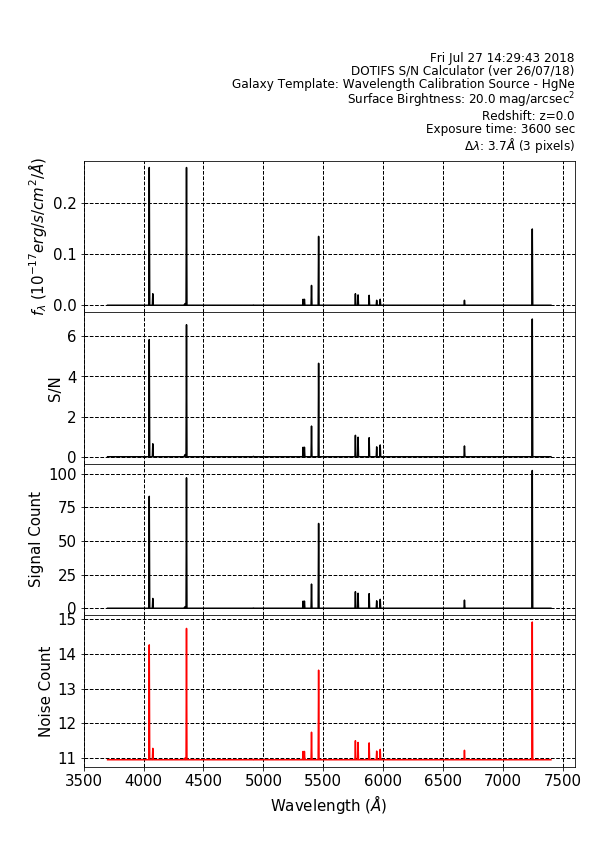

In [172]:
matplotlib.rcParams.update({'font.size':15})
font = {'family' : 'DejaVu Sans',
'weight' : 'normal',
'size'   : 15}

upmar=1.04
lwmar=0.995
wavemar=200

matplotlib.rc('font', **font)


xlim=[min(pwave)-wavemar,max(pwave)+wavemar]

plt.clf
fig=plt.figure(figsize=(8.27,11.69))
#gs1=matplotlib.gridspec.GridSpec(8,12)
gs1=gridspec.GridSpec(4,1, left=None, bottom=0.1, right=0.95, top=0.82, wspace=None, hspace=None)
#gs1.tight_layout(fig, rect=[0,0,0.01,1])
#gs1.subplots_adjust(hspace=0.4, wspace=0.4)
gs1.update(hspace=0.0)
#gs1.tight_layout(fig, rect=[0,0,1,0.5])
#ax=plt.subplot(211)
ax0=plt.subplot(gs1[0])
ax0.plot(pwave, psourceflux/1e-17, 'k', linestyle='-')
ax0.set_xlim(xlim)
ax0.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
ax0.set_ylabel("$f_{\lambda}\;(10^{-17} erg/s/cm^{2}/\AA$)")



ax1=plt.subplot(gs1[1])
ax1.plot(pwave, psnr, 'k', linestyle='-')
#ax.set_ylabel("S/N", fontsize=20)
#ax.set_xlabel("Wavelength $\AA$ ", fontsize=20)
ax1.set_ylabel("S/N")
ax1.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
#ax1.xaxis.set_minor_locator(plt.MultipleLocator(200))
ax1.set_xlim(xlim)

ax2=plt.subplot(gs1[2])
ax2.plot(pwave, psignal, 'k', linestyle='-')
ax2.set_xlim(xlim)
ax2.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
ax2.set_ylabel("Signal Count")

ax3=plt.subplot(gs1[3])
ax3.plot(pwave, pnoise, 'r', linestyle='-')
ax3.set_xlim(xlim)
ax3.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
ax3.set_xlabel("Wavelength ($\AA$) ")
ax3.set_ylabel("Noise Count")

ax0.tick_params(labelbottom=False)#, length=0)
ax1.tick_params(labelbottom=False)#, length=0)
ax2.tick_params(labelbottom=False)#, length=0)

remarks=[time.asctime( time.localtime(time.time()) ),
         'DOTIFS S/N Calculator (ver 26/07/18)',
         'Galaxy Template: '+temptitle,
         'Surface Birghtness: '+str(magnitude)+' mag/arcsec$^{2}$',
         'Redshift: z='+str(z),
         'Exposure time: '+str(exptime)+' sec',
         '$\Delta\lambda$: '+str(round(wstep, 3))+ '$\AA$ ('+str(round(pixel,3))+' pixels)',
        ]

remarks2='\n'.join(remarks)

nremarks=len(remarks)

axc = fig.add_axes([0.000001,0,1,1], facecolor="None", frameon=False, label="")
axc.tick_params(labelbottom=False, labelleft=False, length=0)

yitv=0.02
ax = fig.add_axes([0,0,1,1], facecolor="None", frameon=False, label="")
#ax.text(0.5,0.5, 'AAA')
ax.tick_params(labelbottom=False, labelleft=False, length=0)
#ax.text(0.9, 0.9, 'TEST',horizontalalignment='right')
ax.text(0.95, 0.83, remarks2,horizontalalignment='right', size=12, linespacing=1)
#for i in range(nremarks):
    #ax.text(0.95, 0.83+yitv*i, remarks[nremarks-i-1],horizontalalignment='right', size=10)


val=ax2.get_ylim()
print(val)

val=ax2.get_yticks()
print(val)

#np.set_printoptions(threshold=np.nan)

plt.show()


fig.savefig("foo.pdf", bbox_inches='tight')
fig.savefig("foo.ps", bbox_inches='tight')
        
#def codetest():
#    dotifs_etc(300)
#codetest()

